In [1]:
import torch
import math
import torch.distributions as D
import matplotlib.pyplot as plt

def get_p(r, a):
    one = r*torch.cos(a)+.25
    two = r*torch.sin(a)
    return torch.stack([one, two])

def get_x(r, a, theta):
    p_val = get_p(r, a)
    new1 = -1*torch.sum(theta, -1).abs()/math.sqrt(2)
    new2 = (-1*theta[..., 0]+theta[..., 1])/math.sqrt(2)
    new = torch.stack([new1, new2])
    return (p_val+new).T

def generate_data(n_pts, return_theta=False):
    prior = D.Uniform(torch.tensor([-1., -1.]), torch.tensor([1., 1.]))
    a_dist = D.Uniform(-math.pi/2, math.pi/2)
    r_dist = D.Normal(0.1, .01)

    theta, a, r = prior.sample((n_pts,)), a_dist.sample((n_pts,)), r_dist.sample((n_pts,))
    x = get_x(r, a, theta)
    if return_theta: 
        return theta, x
    else:
        return x

In [2]:
from pyknos.nflows import flows, transforms
from functools import partial
from typing import Optional
from warnings import warn

from pyknos.nflows import distributions as distributions_
from pyknos.nflows import flows, transforms
from pyknos.nflows.nn import nets
from pyknos.nflows.transforms.splines import rational_quadratic
from torch import Tensor, nn, relu, tanh, tensor, uint8

from sbi.utils.sbiutils import (
    standardizing_net,
    standardizing_transform,
    z_score_parser,
)
from sbi.utils.torchutils import create_alternating_binary_mask
from sbi.utils.user_input_checks import check_data_device, check_embedding_net_device

class ContextSplineMap(nn.Module):
    """
    Neural network from `context` to the spline parameters.
    We cannot use the resnet as conditioner to learn each dimension conditioned
    on the other dimensions (because there is only one). Instead, we learn the
    spline parameters directly. In the case of conditinal density estimation,
    we make the spline parameters conditional on the context. This is
    implemented in this class.
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_features: int,
        context_features: int,
        hidden_layers: int,
    ):
        """
        Initialize neural network that learns to predict spline parameters.
        Args:
            in_features: Unused since there is no `conditioner` in 1D.
            out_features: Number of spline parameters.
            hidden_features: Number of hidden units.
            context_features: Number of context features.
        """
        super().__init__()
        # `self.hidden_features` is only defined such that nflows can infer
        # a scaling factor for initializations.
        self.hidden_features = hidden_features

        # Use a non-linearity because otherwise, there will be a linear
        # mapping from context features onto distribution parameters.

        # Initialize with input layer.
        layer_list = [nn.Linear(context_features, hidden_features), nn.ReLU()]
        # Add hidden layers.
        layer_list += [
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
        ] * hidden_layers
        # Add output layer.
        layer_list += [nn.Linear(hidden_features, out_features)]
        self.spline_predictor = nn.Sequential(*layer_list)

    def __call__(self, inputs: Tensor, context: Tensor, *args, **kwargs) -> Tensor:
        """
        Return parameters of the spline given the context.
        Args:
            inputs: Unused. It would usually be the other dimensions, but in
                1D, there are no other dimensions.
            context: Context features.
        Returns:
            Spline parameters.
        """
        return self.spline_predictor(context)

# Declan: this code from SBI library
def build_nsf(
    batch_x: Tensor,
    batch_y: Tensor,
    z_score_x: Optional[str] = "independent",
    z_score_y: Optional[str] = "independent",
    hidden_features: int = 50,
    num_transforms: int = 5,
    num_bins: int = 10,
    embedding_net: nn.Module = nn.Identity(),
    tail_bound: float = 3.0,
    hidden_layers_spline_context: int = 1,
    num_blocks: int = 2,
    dropout_probability: float = 0.0,
    use_batch_norm: bool = False,
    **kwargs,
) -> nn.Module:
    """Builds NSF p(x|y).
    Args:
        batch_x: Batch of xs, used to infer dimensionality and (optional) z-scoring.
        batch_y: Batch of ys, used to infer dimensionality and (optional) z-scoring.
        z_score_x: Whether to z-score xs passing into the network, can be one of:
            - `none`, or None: do not z-score.
            - `independent`: z-score each dimension independently.
            - `structured`: treat dimensions as related, therefore compute mean and std
            over the entire batch, instead of per-dimension. Should be used when each
            sample is, for example, a time series or an image.
        z_score_y: Whether to z-score ys passing into the network, same options as
            z_score_x.
        hidden_features: Number of hidden features.
        num_transforms: Number of transforms.
        num_bins: Number of bins used for the splines.
        embedding_net: Optional embedding network for y.
        tail_bound: tail bound for each spline.
        hidden_layers_spline_context: number of hidden layers of the spline context net
            for one-dimensional x.
        num_blocks: number of blocks used for residual net for context embedding.
        dropout_probability: dropout probability for regularization in residual net.
        use_batch_norm: whether to use batch norm in residual net.
        kwargs: Additional arguments that are passed by the build function but are not
            relevant for maf and are therefore ignored.
    Returns:
        Neural network.
    """
    x_numel = batch_x[0].numel()
    # Infer the output dimensionality of the embedding_net by making a forward pass.
    check_data_device(batch_x, batch_y)
    check_embedding_net_device(embedding_net=embedding_net, datum=batch_y)
    y_numel = embedding_net(batch_y[:1]).numel()

    # Define mask function to alternate between predicted x-dimensions.
    def mask_in_layer(i):
        return create_alternating_binary_mask(features=x_numel, even=(i % 2 == 0))

    # If x is just a scalar then use a dummy mask and learn spline parameters using the
    # conditioning variables only.
    if x_numel == 1:
        # Conditioner ignores the data and uses the conditioning variables only.
        conditioner = partial(
            ContextSplineMap,
            hidden_features=hidden_features,
            context_features=y_numel,
            hidden_layers=hidden_layers_spline_context,
        )
    else:
        # Use conditional resnet as spline conditioner.
        conditioner = partial(
            nets.ResidualNet,
            hidden_features=hidden_features,
            context_features=y_numel,
            num_blocks=num_blocks,
            activation=relu,
            dropout_probability=dropout_probability,
            use_batch_norm=use_batch_norm,
        )

    # Stack spline transforms.
    transform_list = []
    for i in range(num_transforms):
        block = [
            transforms.PiecewiseRationalQuadraticCouplingTransform(
                mask=mask_in_layer(i) if x_numel > 1 else tensor([1], dtype=uint8),
                transform_net_create_fn=conditioner,
                num_bins=num_bins,
                tails="linear",
                tail_bound=tail_bound,
                apply_unconditional_transform=False,
            )
        ]
        # Add LU transform only for high D x. Permutation makes sense only for more than
        # one feature.
        if x_numel > 1:
            block.append(
                transforms.LULinear(x_numel, identity_init=True),
            )
        transform_list += block

    z_score_x_bool, structured_x = z_score_parser(z_score_x)
    if z_score_x_bool:
        # Prepend standardizing transform to nsf transforms.
        transform_list = [
            standardizing_transform(batch_x, structured_x)
        ] + transform_list

    z_score_y_bool, structured_y = z_score_parser(z_score_y)
    if z_score_y_bool:
        # Prepend standardizing transform to y-embedding.
        embedding_net = nn.Sequential(
            standardizing_net(batch_y, structured_y), embedding_net
        )

    distribution = distributions_.StandardNormal((x_numel,))

    # Combine transforms.
    transform = transforms.CompositeTransform(transform_list)
    neural_net = flows.Flow(transform, distribution, embedding_net)

    return neural_net



class EmbeddingNet(nn.Module):
    def __init__(self, dim):
        super(EmbeddingNet, self).__init__()
        self.context_dim = dim
        self.dense = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
        )


    def forward(self, x):
        '''
        Assumes context x is of shape (batch_size, self.context_dim)
        '''
        return self.dense(x)


In [3]:
theta, x = generate_data(100, return_theta=True) 

prior = D.Uniform(torch.tensor([-1., -1.]), torch.tensor([1., 1.]))
a_dist = D.Uniform(-math.pi/2, math.pi/2)
r_dist = D.Normal(0.1, .01)
mb_size=100
device='cuda:0'
kwargs = {'prior': prior,
        'a_dist': a_dist,
        'r_dist': r_dist}

# EXAMPLE BATCH FOR SHAPES
z_dim = prior.sample().shape[-1]
x_dim = x.shape[-1]
num_obs_flow = mb_size
fake_zs = torch.randn((mb_size, z_dim))
fake_xs = torch.randn((mb_size, x_dim))
encoder = build_nsf(fake_zs, fake_xs, z_score_x='none', z_score_y='none')

encoder.to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

In [4]:
for j in range(5000):
    theta, x = generate_data(mb_size, return_theta=True)
    optimizer.zero_grad()
    loss = -1*encoder.log_prob(theta.to(device), x.to(device)).mean()
    loss.backward()
    optimizer.step()
    print('Iteration {}: loss {}'.format(j, loss.item()))

Iteration 0: loss 2.3429114818573
Iteration 1: loss 2.315995454788208
Iteration 2: loss 2.223140001296997
Iteration 3: loss 2.1706759929656982
Iteration 4: loss 2.151491403579712
Iteration 5: loss 2.1638033390045166
Iteration 6: loss 1.9986634254455566
Iteration 7: loss 2.0684454441070557
Iteration 8: loss 2.0603621006011963
Iteration 9: loss 2.0044567584991455
Iteration 10: loss 1.963956594467163
Iteration 11: loss 1.9947948455810547
Iteration 12: loss 1.871052622795105
Iteration 13: loss 1.8245301246643066
Iteration 14: loss 1.785322666168213
Iteration 15: loss 1.7284806966781616
Iteration 16: loss 1.724053144454956
Iteration 17: loss 1.6478590965270996
Iteration 18: loss 1.6552882194519043
Iteration 19: loss 1.568678855895996
Iteration 20: loss 1.5853935480117798
Iteration 21: loss 1.541748046875
Iteration 22: loss 1.5008190870285034
Iteration 23: loss 1.4572502374649048
Iteration 24: loss 1.3156825304031372
Iteration 25: loss 1.3414415121078491
Iteration 26: loss 1.2961010932922363

In [53]:
import numpy as np

calibration_theta, calibration_x = generate_data(100, return_theta=True)
cal_scores = []
for calibration_theta_pt, calibration_x_pt in zip(calibration_theta, calibration_x):
    log_prob = encoder.log_prob(calibration_theta_pt.view(1,-1).to(device), calibration_x_pt.view(1,-1).to(device)).detach()
    prob = log_prob.cpu().exp().numpy()
    cal_scores.append(1 / prob)
cal_scores = np.array(cal_scores)

In [73]:
def log_post(x, theta, **kwargs):
    '''vectorized version of the above in theta for fixed x'''
    assert theta.shape[1] == 2, "not yet implemented for evaluation on multiple points at once"
    r_dist = kwargs['r_dist']
    new1 = -1*torch.sum(theta, 1).abs()/math.sqrt(2)
    new2 = (-1*theta[:,0]+theta[:,1])/math.sqrt(2)
    new = torch.stack([new1, new2]).T
    p = x-new
    u = p[:,0]-.25
    v = p[:,1]
    r = torch.sqrt(u ** 2 + v ** 2)  # note the angle distribution is uniform
    to_adjust = r_dist.log_prob(r)
    adjusted = torch.where(u < 0.0, -torch.inf, to_adjust.double())
    return adjusted

# Code to plot the true posterior density
def plot(j, x, encoder, **kwargs):
    device = 'cuda:0'

    # Plot exact density
    vals = torch.arange(-1., 1., .01)
    eval_pts = torch.cartesian_prod(vals, vals)
    lps = log_post(x[j], eval_pts, **kwargs)
    X, Y = torch.meshgrid(vals, vals)
    Z = lps.view(X.shape)

    nrows = 4
    ncols = 3
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24,24))
    ax[0,0].pcolormesh(X.numpy(), Y.numpy(), Z.exp().numpy())
    ax[0,0].set_title('Exact')
    

    vals = torch.arange(-1., 1., .01)
    eval_pts = torch.cartesian_prod(vals, vals)
    lps = encoder.log_prob(eval_pts.to(device), x[j].view(1,-1).repeat(eval_pts.shape[0],1).to(device)).detach()
    X, Y = torch.meshgrid(vals, vals)
    Z = lps.view(X.shape)
    ax[0,1].pcolormesh(X.cpu().numpy(), Y.cpu().numpy(), Z.cpu().exp().numpy())
    ax[0,1].set_title('Approximate Posterior Flow')

    remaining_spots = nrows * ncols - 2
    for k in range(remaining_spots):
        coverage_guarantee = 0.1 * k
        qhat = np.quantile(cal_scores, q = coverage_guarantee)
        prob_min = 1 / qhat

        graphic_idx = k + 2
        row_idx = graphic_idx // ncols
        col_idx = graphic_idx - row_idx * ncols
        ax[row_idx,col_idx].pcolormesh(X.cpu().numpy(), Y.cpu().numpy(), Z.cpu().exp().numpy() > prob_min)
        ax[row_idx,col_idx].set_title(f'Conformalized Posterior: q={coverage_guarantee}')

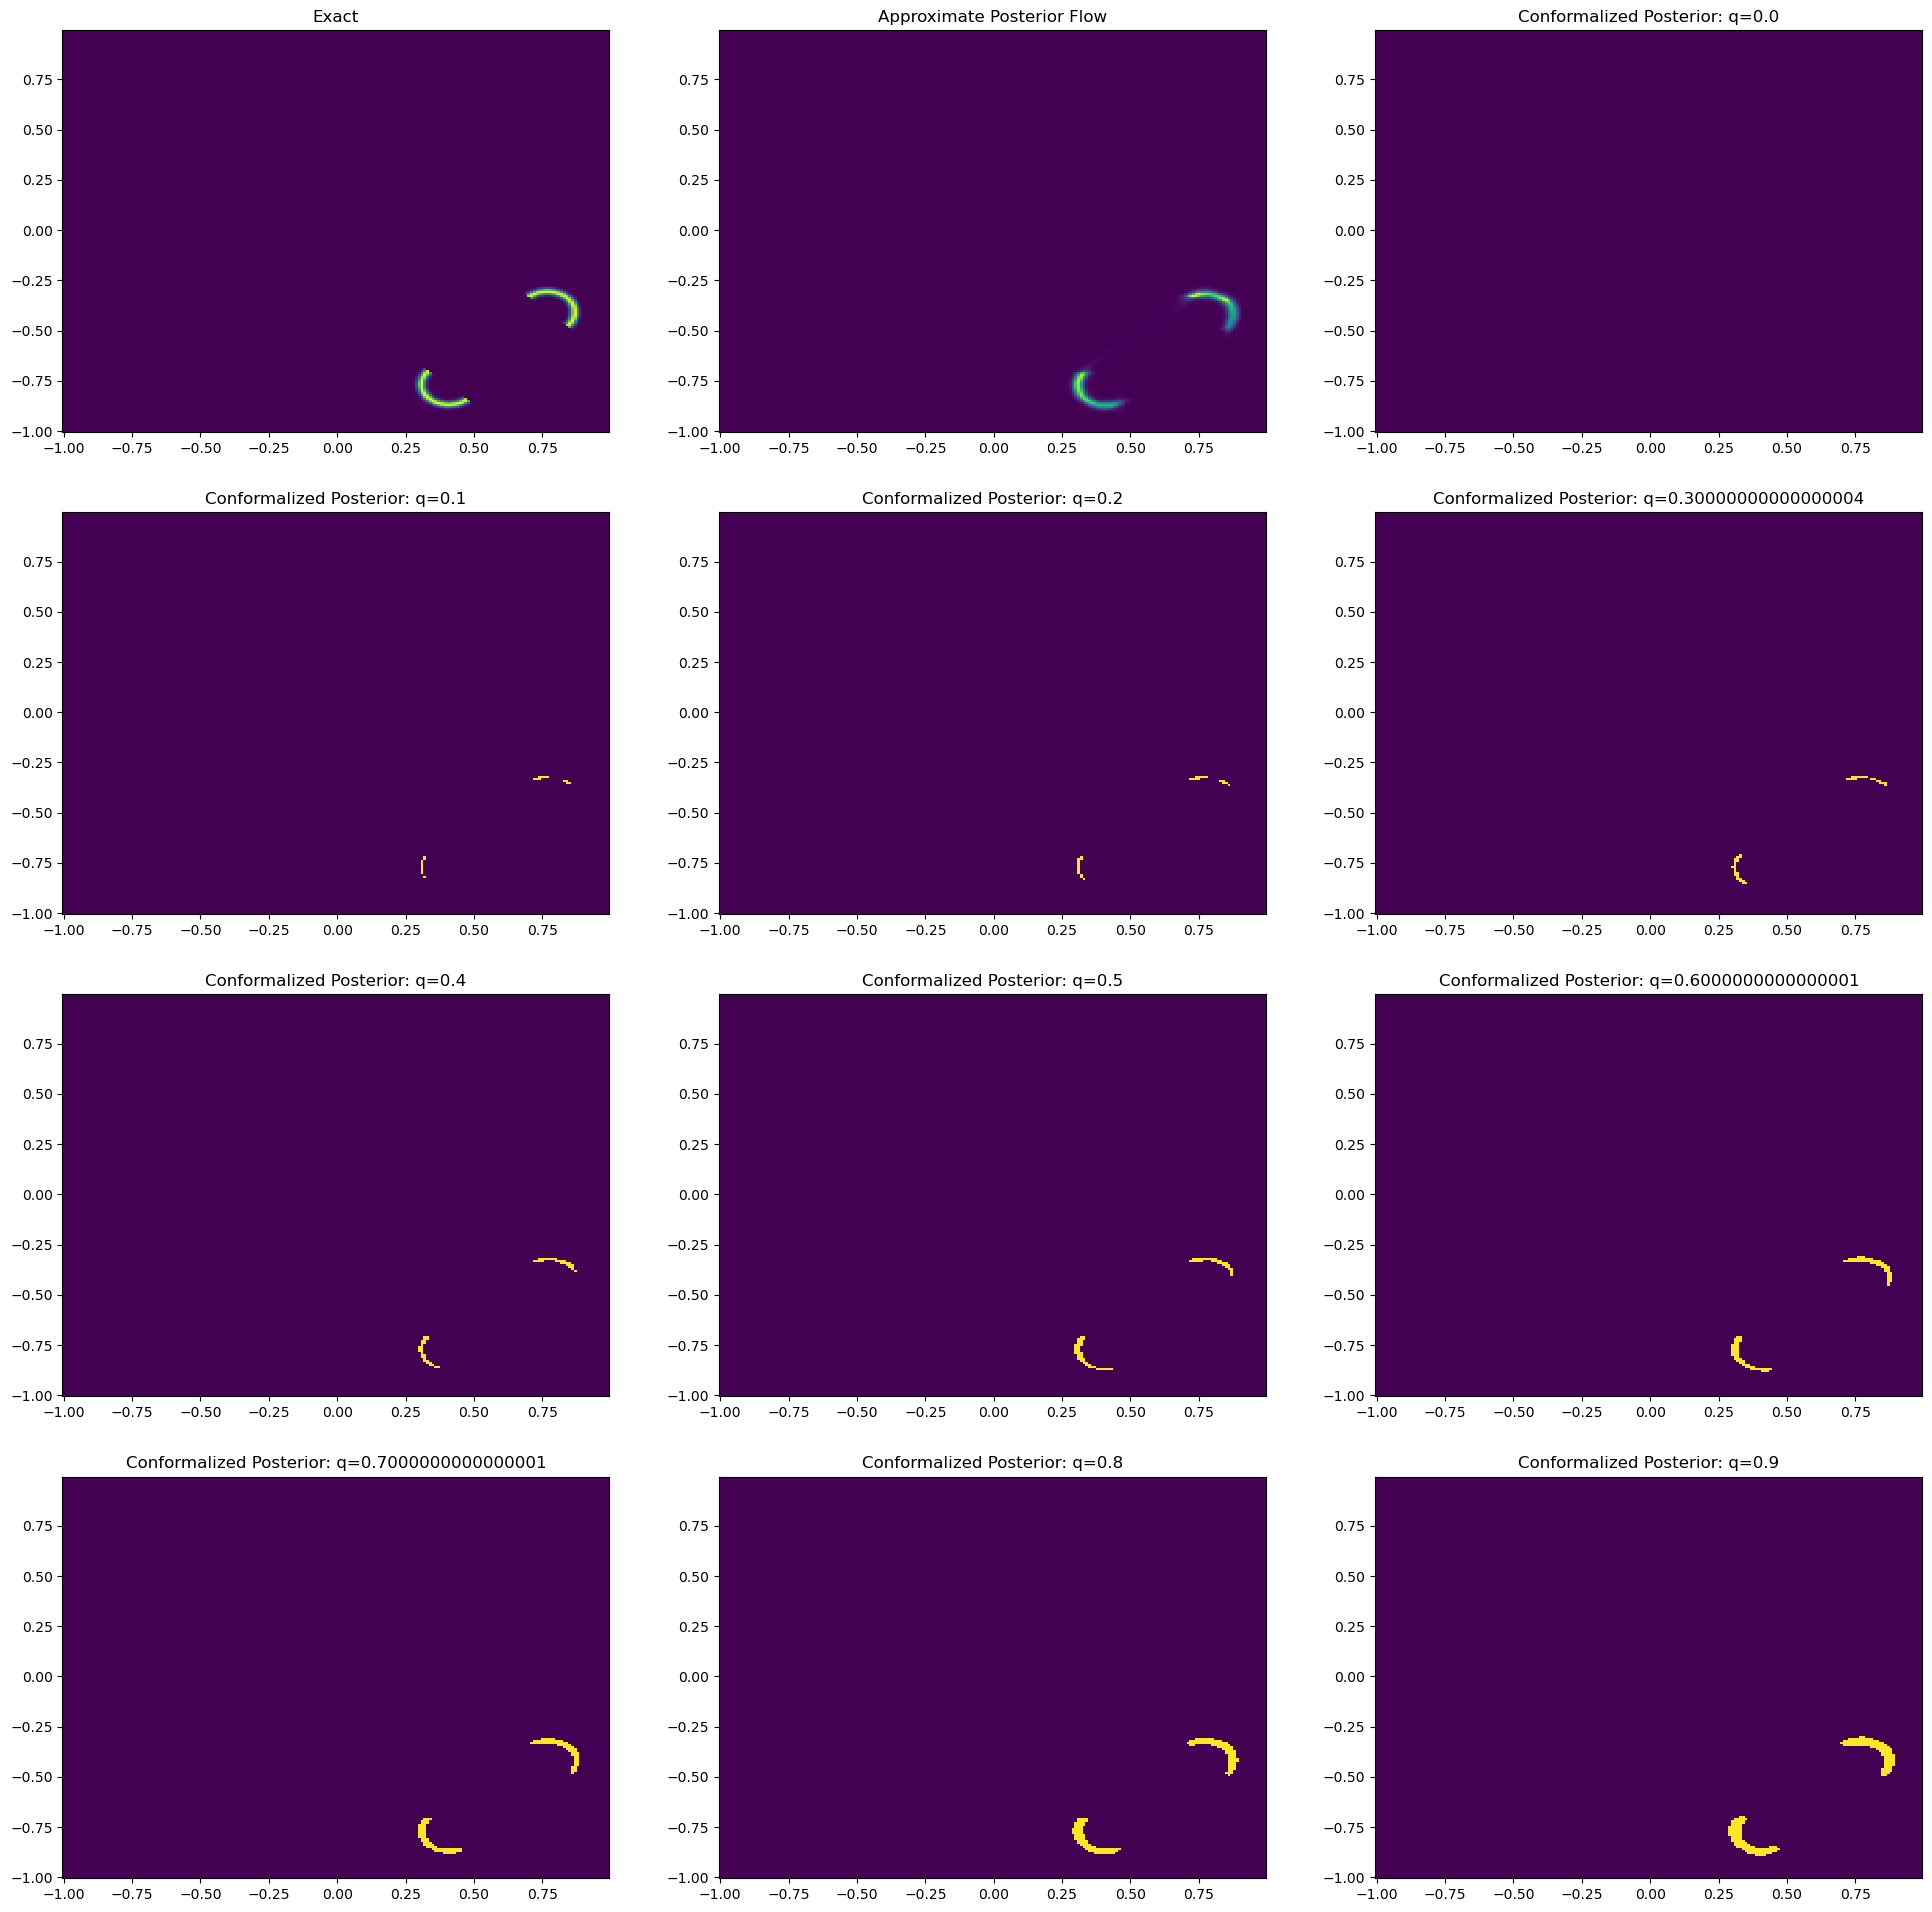

In [74]:

plot(j=5, x=x, encoder=encoder, **kwargs)

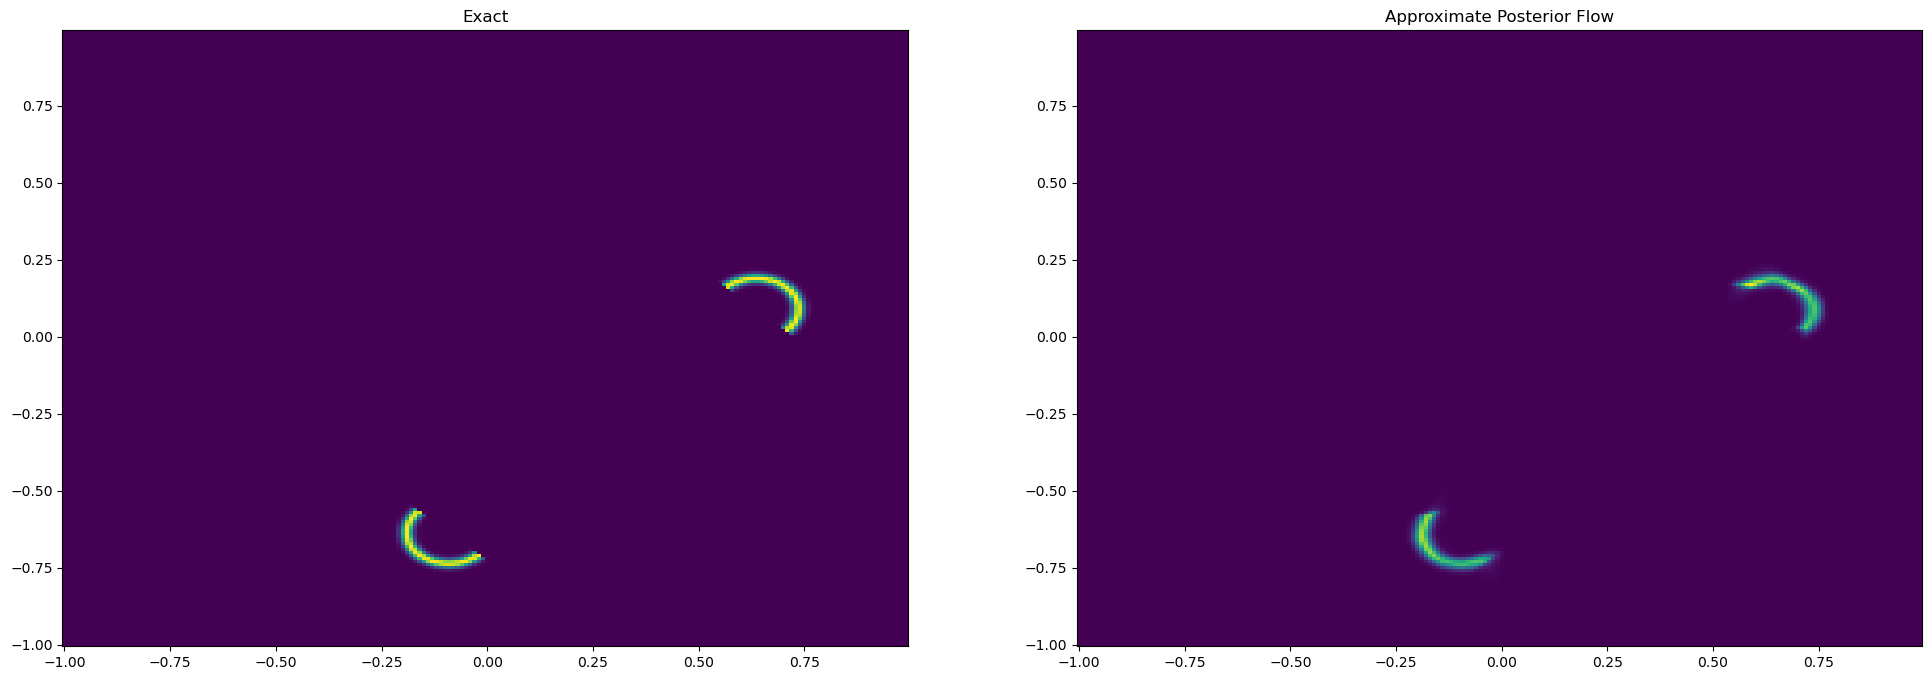

In [10]:
plot(j=3, x=x, encoder=encoder, **kwargs)